# House Price Predictor

In [1]:
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_validate, ParameterGrid
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

In [2]:
# load data
data = pd.read_csv('data/challenge_houses-prices.csv')
data.shape

(50000, 18)

**Training & Test Data**

In [3]:
SEED = 178

In [4]:
data_train, data_test = train_test_split(
    data, test_size=0.1, random_state=SEED,
)
data_train.shape

(45000, 18)

### Data Preprocessing

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 19692 to 12815
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_area         45000 non-null  int64  
 1   house_age             45000 non-null  int64  
 2   house_style           45000 non-null  object 
 3   neighborhood          45000 non-null  object 
 4   overall_quality       45000 non-null  int64  
 5   overall_condition     45000 non-null  int64  
 6   spaciousness          45000 non-null  float64
 7   liv_lot_ratio         45000 non-null  float64
 8   remodel_age           45000 non-null  int64  
 9   bath_area             45000 non-null  float64
 10  bsmt_area             45000 non-null  int64  
 11  garage_area           45000 non-null  int64  
 12  garage_age            44261 non-null  float64
 13  has_2ndfloor          45000 non-null  int64  
 14  has_porch             45000 non-null  int64  
 15  has_pool       

In [5]:
# target
y_train = data_train['sale_price'].values
data_train['sale_price'].describe()

count     45000.000000
mean     178341.326556
std       69422.137632
min       34900.000000
25%      127389.750000
50%      158565.500000
75%      221928.000000
max      675054.000000
Name: sale_price, dtype: float64

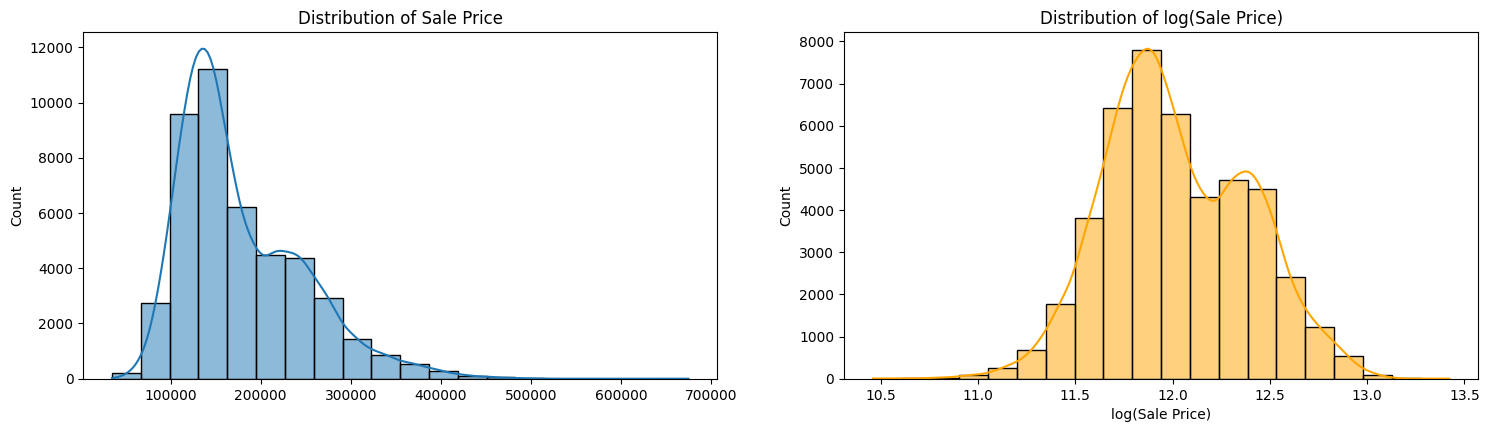

In [7]:
plt.figure(figsize=(18, 4.5))

plt.subplot(121)
sns.histplot(y_train, bins=20, kde=True)
plt.title("Distribution of Sale Price")

plt.subplot(122)
sns.histplot(np.log(y_train), bins=20, kde=True, color="orange")
plt.xlabel("log(Sale Price)")
plt.title("Distribution of log(Sale Price)")

plt.show()

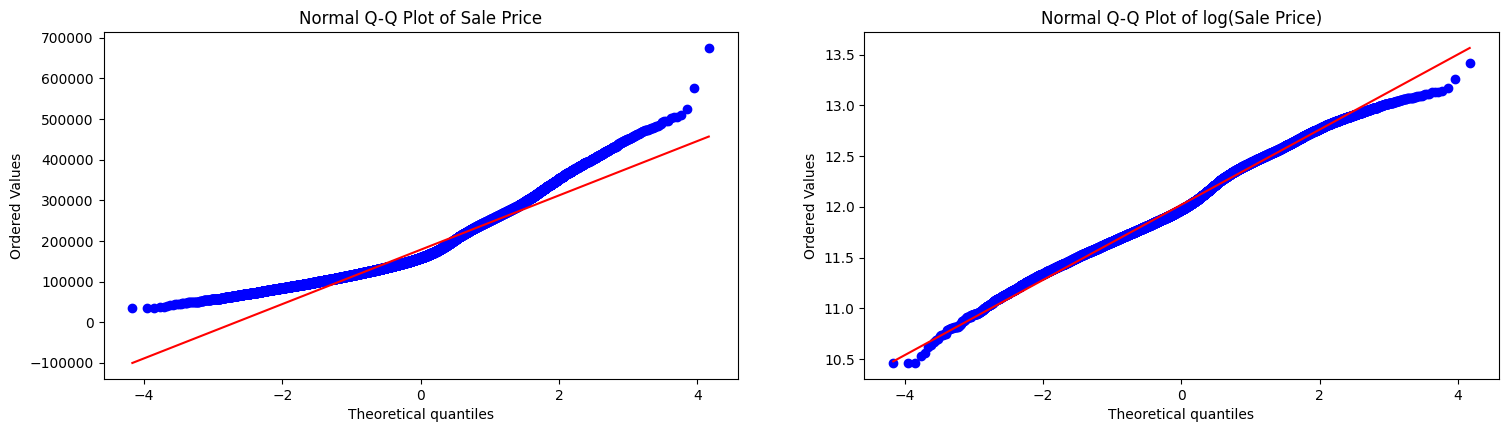

In [8]:
fig = plt.figure(figsize=(18, 4.5))

ax = fig.add_subplot(121)
probplot(y_train, plot=ax)
plt.title("Normal Q-Q Plot of Sale Price")

ax = fig.add_subplot(122)
probplot(np.log(y_train), plot=ax)
plt.title("Normal Q-Q Plot of log(Sale Price)")

plt.show()

In [6]:
y_train = np.log(data_train['sale_price'].values)

In [7]:
# categorical columns to numeric: mean encoding
categorical_features = ['house_style', 'neighborhood']
cat_maps = {}
for column in categorical_features:
    ucat = data_train[column].unique()
    cat_maps[column] = {x:np.mean(y_train[data_train[column] == x]) for x in ucat}
    data_train[column] = data_train[column].map(cat_maps[column])

In [8]:
# fill nan values in garage_age
features_median = dict(zip(data_train.columns, np.nanmedian(data_train.values, axis=0)))
nan_features = ['garage_age']
for col in nan_features:
    data_train.loc[data_train[col].isna(), col] = features_median[col]

### Feature Engineering

In [9]:
# remove features with low variance
features_to_remove = {'sale_price'}
feature_names = np.array(data_train.columns)
features_to_remove.update(set(feature_names[np.where(np.std(data_train.values, axis=0) == 0)[0]]))
features_to_remove

{'has_pool', 'sale_price'}

In [21]:
X_train = data_train.copy()
for col in features_to_remove:
    X_train = X_train.drop(col, axis=1)
X_train.shape

(45000, 16)

In [22]:
# feature relevance: keep top 10
fcorr = np.abs(np.corrcoef(X_train.values, y_train, rowvar=False)[-1][0:-1])
fmi = mutual_info_regression(X_train.values, y_train)

In [23]:
relevance = pd.DataFrame({
    'feature': X_train.columns,
    'correlation': fcorr,
    'mutual_information': fmi,
})
relevance.sort_values('mutual_information', ascending=False, inplace=True, ignore_index=True)
relevance

,feature,correlation,mutual_information
0,overall_quality,0.803224,0.520966
1,neighborhood,0.740119,0.411360
2,bath_area,0.726964,0.394096
3,property_area,0.714173,0.374958
4,garage_area,0.676193,0.335378
5,garage_age,0.585311,0.295807
6,house_age,0.590462,0.290059
7,spaciousness,0.619981,0.274701
8,remodel_age,0.624522,0.273134
9,bsmt_area,0.518707,0.165460


In [24]:
features_selected = relevance['feature'].values[:10]
features_selected

array(['overall_quality', 'neighborhood', 'bath_area', 'property_area',
       'garage_area', 'garage_age', 'house_age', 'spaciousness',
       'remodel_age', 'bsmt_area'], dtype=object)

In [25]:
X_train = X_train.loc[:, features_selected]
X_train.shape

(45000, 10)

In [26]:
# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_train.shape

(45000, 10)

### Model Training

In [28]:
# apply pre-preprocessing to test-data
y_test = np.log(data_test['sale_price'])
X_test = data_test.loc[:, features_selected]
# categorical features
for col in cat_maps:
    if col in X_test.columns:
        X_test[col] = X_test[col].map(cat_maps[col])
# fill nan values
for col in X_test.columns:
    X_test.loc[X_test[col].isna(), col] = features_median[col]
# scale
X_test = scaler.transform(X_test.values)
X_test.shape

(5000, 10)

In [79]:
# tune model: Support Vector Regressor
model_params = {
    "max_depth": [10],
    "n_estimators": list(np.arange(10, 210, 10)),
}
grid_results = []
best_perf = 1
for params in ParameterGrid(model_params):
    model = RandomForestRegressor(random_state=SEED, **params)
    model.fit(X_train, y_train)
    # perf metrics
    ytrain_pred = model.predict(X_train)
    ytest_pred = model.predict(X_test)
    params.update({
        'train_rmse': np.sqrt(np.mean((y_train - ytrain_pred)**2)),
        'train_mae': np.mean(np.abs(y_train - ytrain_pred)),
        'test_rmse': np.sqrt(np.mean((y_test - ytest_pred)**2)),
        'test_mae': np.mean(np.abs(y_test - ytest_pred)),
    })
    grid_results.append(params)
    if params['test_mae'] < best_perf:
        print(params)
        best_perf = params['test_mae']
    del model

{'max_depth': 10, 'n_estimators': 10, 'train_rmse': 0.17279949413082987, 'train_mae': 0.13625071162591876, 'test_rmse': 0.1895436476759949, 'test_mae': 0.14905881870119292}
{'max_depth': 10, 'n_estimators': 20, 'train_rmse': 0.17209184663068744, 'train_mae': 0.13594963961096596, 'test_rmse': 0.18874730091887787, 'test_mae': 0.148406155693077}
{'max_depth': 10, 'n_estimators': 50, 'train_rmse': 0.17153170567335782, 'train_mae': 0.13558121880913318, 'test_rmse': 0.1886619226915597, 'test_mae': 0.1483761444471175}
{'max_depth': 10, 'n_estimators': 70, 'train_rmse': 0.17142963793787352, 'train_mae': 0.13551512092949558, 'test_rmse': 0.18869246185697777, 'test_mae': 0.1483348278228724}
{'max_depth': 10, 'n_estimators': 80, 'train_rmse': 0.1713789474685089, 'train_mae': 0.13547855759641605, 'test_rmse': 0.188647596946776, 'test_mae': 0.14826541697911116}
{'max_depth': 10, 'n_estimators': 90, 'train_rmse': 0.17137605034334086, 'train_mae': 0.13547978727079188, 'test_rmse': 0.18865677329452774

In [80]:
# best model
grid_results_df = pd.DataFrame(grid_results)
grid_results_df.sort_values('test_mae', ignore_index=True, inplace=True)
grid_results_df

,max_depth,n_estimators,train_rmse,train_mae,test_rmse,test_mae
0,10,120,0.171326,0.135438,0.188627,0.148215
1,10,110,0.171327,0.135439,0.188630,0.148217
2,10,130,0.171346,0.135455,0.188618,0.148224
3,10,100,0.171348,0.135460,0.188660,0.148238
4,10,90,0.171376,0.135480,0.188657,0.148248
5,10,190,0.171315,0.135429,0.188586,0.148253
6,10,170,0.171319,0.135436,0.188588,0.148260
7,10,160,0.171343,0.135453,0.188622,0.148261
8,10,80,0.171379,0.135479,0.188648,0.148265
9,10,200,0.171307,0.135416,0.188593,0.148267


In [81]:
# model selected
model = RandomForestRegressor(
    max_depth=10,
    n_estimators=120,
    random_state=SEED,
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=120, random_state=178)

In [82]:
# perf metrics
ytrain_pred = model.predict(X_train)
ytest_pred = model.predict(X_test)
perf_metrics = {
    'train': {
        'rmse': np.round(np.sqrt(np.mean((np.exp(y_train) - np.exp(ytrain_pred))**2)), 3),
        'mae': np.round(np.mean(np.abs(np.exp(y_train) - np.exp(ytrain_pred))), 3),
    },
    'test': {
        'rmse': np.round(np.sqrt(np.mean((np.exp(y_test) - np.exp(ytest_pred))**2)), 3),
        'mae': np.round(np.mean(np.abs(np.exp(y_test) - np.exp(ytest_pred))), 3),
    },
}
perf_metrics

{'train': {'rmse': 31935.587, 'mae': 23830.703},
 'test': {'rmse': 34565.065, 'mae': 25918.754}}

In [83]:
# save model
house_price_predictor = {
    'features_selected': features_selected,
    'categorical_maps': cat_maps,
    'features_median': features_median,
    'scaler': scaler,
    'model': model,
    'metrics': perf_metrics,
}
with open('data/house_price_model.pickle', 'wb') as file:
    pickle.dump(house_price_predictor, file)

### Model Test

In [65]:
# test model
test_list = data_test.iloc[:, 0:-1].to_dict('records')
with open('data/test_data.pickle', 'wb') as file:
    pickle.dump(test_list, file)

In [85]:
np.exp(ytest_pred[0])

170124.43740752706

In [66]:
test_list[0]

{'property_area': 2316,
 'house_age': 4,
 'house_style': '2Story',
 'neighborhood': 'Gilbert',
 'overall_quality': 6,
 'overall_condition': 5,
 'spaciousness': 269.0,
 'liv_lot_ratio': 0.0,
 'remodel_age': 8,
 'bath_area': 2.5,
 'bsmt_area': 1009,
 'garage_area': 461,
 'garage_age': 6.0,
 'has_2ndfloor': 1,
 'has_porch': 1,
 'has_pool': 0,
 'has_multiple_kitchen': 0}

In [68]:
def model_predict(input_dict):
    input_array = np.zeros(len(features_selected))
    for i, fname in enumerate(features_selected):
        if fname in cat_maps:
            input_array[i] = cat_maps[fname][input_dict[fname]]
        elif np.isnan(input_dict[fname]):
            input_array[i] = features_median[fname]
        else:
            input_array[i] = input_dict[fname]
    input_array = scaler.transform(input_array.reshape(1, -1))
    return np.exp(model.predict(input_array))[0]

In [84]:
model_predict(test_list[0])

170124.43740752706